# The TLC trip record data

<img align="left" src="files/tlc.png">

Data source: http://www.nyc.gov/html/tlc/html/about/trip_record_data.shtml  

This notebook heavily borrows from https://www.kaggle.com/kartikkannapur/nyc-taxi-trips-exploratory-data-analysis/  

## Content

1. [Clean training data](#1.-Clean-training-data)
2. [Extract features](#2.-Extract-features)
    * [Extract datetime categorical features](#-Extract-datetime-categorical-features)
    * [Calculate trip distance](#-Calculate-trip-distance)
    * [Bin geolocation fields](#-Bin-geolocation-fields)
3. [Features transformation](#3.-Features-transformation)
4. [Build model](#4.-Build-model)
5. [Test model](#5.-Test-model)
6. [Evaluate model](#6.-Evaluate-model)

### The Data Set

Records of taxi trips in New York City including pickup time, geo-coordinates, the number of passengers, and various other variables.

### Data fields

* id - a unique identifier for each trip
* vendor_id - a code indicating the provider associated with the trip record
* pickup_datetime - date and time when the meter was engaged
* dropoff_datetime - date and time when the meter was disengaged
* passenger_count - the number of passengers in the vehicle (driver entered value)
* pickup_longitude - the longitude where the meter was engaged
* pickup_latitude - the latitude where the meter was engaged
* dropoff_longitude - the longitude where the meter was disengaged
* dropoff_latitude - the latitude where the meter was disengaged
* store_and_fwd_flag - This flag indicates whether the trip record was held in vehicle memory before sending to the vendor because the vehicle did not have a connection to the server - Y=store and forward; N=not a store and forward trip
* trip_duration - duration of the trip in seconds

### The Use Case

We want to build a model to predict the trip duration of a taxi driver based on the features of the trip.

Our goal is to predict the duration of those most common trips in NYC, short distance (20km) and short duration (no more than 4h). 

This model will allow us to estimate the amount of time that the taxi drivers will take to be available again.

In [420]:
import datetime
import os
import sys
import time
import timeit

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from haversine import haversine
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

Please, download the train and tests data sets from the [original Kaggle competition](https://www.kaggle.com/c/nyc-taxi-trip-duration/data) and move them into a folder "data" in the current directory.

In [463]:
# read data from csv
df_train = pd.read_csv("../week2/data/train.csv")

In [524]:
df_train.columns

Index(['id', 'vendor_id', 'pickup_datetime', 'dropoff_datetime',
       'passenger_count', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag',
       'trip_duration', 'pickup_hour', 'pickup_weekday_name', 'pickup_month',
       'pickup_weekday_int', 'haversine_apprx_distance', 'binned_long',
       'binned_lat'],
      dtype='object')

## 1. Clean data

#### Remove outliers from target

We only want to predict trips that took less than 4h which is 1h x 60m x 60s = 3600s.

In [464]:
# Make a selection in the pandas data frame by "trip_duration"
df_train_clean = df_train[df_train['trip_duration'] < 3600].copy()

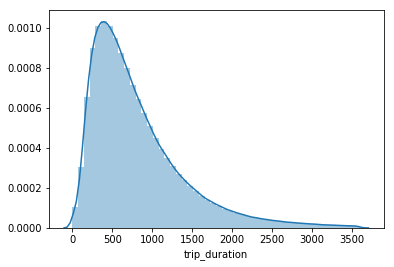

In [465]:
# Visualize distribution of selected training set
sns.distplot(df_train_clean['trip_duration'])

## 2. Extract features

### 2.1. Extract categorical features from datetime

Which temporal features can we extract?
* Pickup hour
* Pickup day
* Pickup month

In [466]:
# Ensure that "pickup_datetime" is of type datetime to extract information
df_train_clean["pickup_datetime"] = pd.to_datetime(df_train_clean["pickup_datetime"])

In [467]:
# Extract pickup hour of each record as a new feature
df_train_clean["pickup_hour"] = df_train_clean.pickup_datetime.dt.hour

# Extract pickup day of each record as a new feature
df_train_clean["pickup_weekday_name"] = df_train_clean.pickup_datetime.dt.weekday_name

# Extract pickup month of each record as a new feature
df_train_clean["pickup_month"] = df_train_clean.pickup_datetime.dt.month

These features are categorical but it could be that they are as integers.

We need to have categories labeled with integers for a step that we will explain afterwards.

In [468]:
# Build a dictionary with each string and the integer label
## Define keys of dictionary
days_of_week = df_train_clean["pickup_weekday_name"].unique()

## Define values of dictionary
int_labels = [i for i in range(len(days_of_week))]

## Build the dictionary
days_week_mapper = dict(zip(days_of_week, int_labels))

## Build the integer day of the week feature
df_train_clean["pickup_weekday_int"] = df_train_clean["pickup_weekday_name"].apply(lambda name: days_week_mapper[name])

In [469]:
# Simple solution in this case 
# df_train_clean["pickup_weekday_int"] = df_train_clean.pickup_datetime.dt.dayofweek

### 2.2. Calculate trip distance

In [499]:
def calculate_haversine_distance(var_row):
    return haversine((var_row["pickup_latitude"], var_row["pickup_longitude"]), 
                     (var_row["dropoff_latitude"], var_row["dropoff_longitude"]),
                     miles=False) # returning distance in 

In [500]:
# Use the method above to calculate "haversine_distance"
#start = timeit.default_timer()
#df_train_clean["haversine_distance"] = df_train_clean.apply(lambda row: calculate_haversine_distance(row), axis=1)
#stop = timeit.default_timer()
#print(stop - start)

298.70092353899963


In [471]:
def haversine_np(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points
    on the earth (specified in decimal degrees)

    All args must be of equal length.    

    """
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2

    c = 2 * np.arcsin(np.sqrt(a))
    km = 6367 * c
    return km

In [472]:
# Use the method above to calculate "haversine_distance" column based
start = timeit.default_timer()
df_train_clean["haversine_apprx_distance"] = haversine_np(df_train_clean["pickup_longitude"], 
                                                            df_train_clean["pickup_latitude"], 
                                                            df_train_clean["dropoff_longitude"], 
                                                            df_train_clean["dropoff_latitude"])
stop = timeit.default_timer()
print(stop - start)

0.38543028500134824


Visualize differences between results for each of the methods:

In [504]:
df_train_clean["haversine_distance"].head()

0    1.498521
1    1.805507
2    6.385098
3    1.485498
4    1.188588
Name: haversine_distance, dtype: float64

In [473]:
df_train_clean["haversine_apprx_distance"].head()

0    1.497580
1    1.804374
2    6.381090
3    1.484566
4    1.187842
Name: haversine_apprx_distance, dtype: float64

###### Select only trips of our interest (within 50 km)

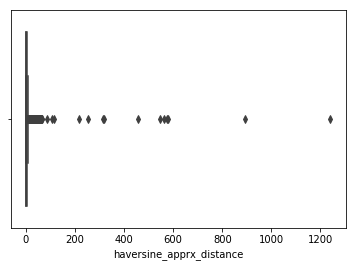

In [474]:
# Visualize distribution of trips distances
sns.boxplot(df_train_clean["haversine_apprx_distance"])

In [475]:
# We want to select only those trips that with a distance within 50 km
df_train_clean = df_train_clean[df_train_clean["haversine_apprx_distance"] < 50]

### 2.3. Bin geolocation fields

How can we label locations in New York based on the latitude and longitude values?
* Parse our data through a mapper of postal code to lat/long
* Cluster latitude and longitude locations
* Bin continuous latitude and longitude features in n categories of same width
* Bin continuous latitude and longitude features in n categories of same proportion of number of samples

#### Define bins' boundaries

In [476]:
def extract_max_min(pickup_geo):
    max_geo = max(pickup_geo)
    min_geo = min(pickup_geo)
    return max_geo, min_geo

In [477]:
max_long, min_long = extract_max_min(df_train_clean["pickup_longitude"])
max_lat, min_lat = extract_max_min(df_train_clean["pickup_latitude"])
print("Maximum and minimum longitude: [{}, {}]\nMaximum and minimum latitude: [{}, {}]".format(max_long, min_long,
                                                                                           max_lat, min_lat))

Maximum and minimum longitude: [-61.33552932739258, -121.93334197998048]
Maximum and minimum latitude: [43.91176223754883, 34.359695434570305]


It looks like the area much bigger than the area of New York!!

This picture have these boundaries:
* North: 41.0569573,-73.8312268
* South: 40.2626255,-74.0104418
* West: 40.6201136,-74.5482892
* East: 40.6774526,-73.1360556

![title](nyc_selection.png)

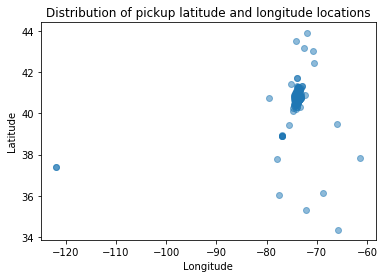

In [478]:
# Visualize distribution of pickup locations
plt.scatter(df_train_clean["pickup_longitude"], df_train_clean["pickup_latitude"], alpha=0.5)
plt.title("Distribution of pickup latitude and longitude locations")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

#### Build bins

In [479]:
def extract_bin_labels_from_series(maximum, minimum, num_bins, data):
    # Create equally separated bins in the restricted area of interest
    bins_boundaries = np.linspace(start=minimum, stop=maximum, num=num_bins)
    
    # Create two more bins for outliers
    bins_boundaries_complete = np.concatenate([[-1000], bins_boundaries, [1000]])
    
    # Bin the data according to bins defined
    return pd.cut(data, bins=bins_boundaries_complete, labels=np.arange(0, num_bins + 1)).astype(int) 

In [480]:
# Define manually geo box for New York as in the picture
nyc_max_long, nyc_min_long = [-73.1360556, -74.5482892]
nyc_max_lat, nyc_min_lat = [41.0569573, 40.2626255]

In [481]:
# Select only the data within the box of New York
cond_long = (df_train_clean["pickup_longitude"] > nyc_min_long) & (df_train_clean["pickup_longitude"] < nyc_max_long)
cond_lat = (df_train_clean["pickup_latitude"] > nyc_min_lat) & (df_train_clean["pickup_latitude"] < nyc_max_lat)
df_train_clean = df_train_clean[cond_long & cond_lat]

In [482]:
# Assign bin labels for latitude and longitud grid
df_train_clean['binned_long'] = extract_bin_labels_from_series(nyc_max_long, nyc_min_long, 
                                                               9, df_train_clean["pickup_longitude"])
df_train_clean['binned_lat'] = extract_bin_labels_from_series(nyc_max_lat, nyc_min_lat, 9, 
                                                              df_train_clean["pickup_latitude"])

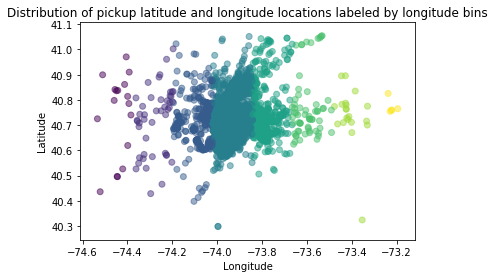

In [501]:
# Visualize distribution of bins for longitude
plt.scatter(df_train_clean["pickup_longitude"], df_train_clean["pickup_latitude"], 
            c=df_train_clean['binned_long'] ,alpha=0.5)
plt.title("Distribution of pickup latitude and longitude locations labeled by longitude bins")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

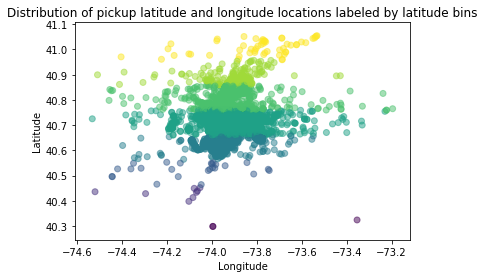

In [502]:
# Visualize distribution of bins for latitude
plt.scatter(df_train_clean["pickup_longitude"], df_train_clean["pickup_latitude"], 
            c=df_train_clean['binned_lat'] ,alpha=0.5)
plt.title("Distribution of pickup latitude and longitude locations labeled by latitude bins")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

## 3. Features transformation

In [483]:
# Define type of features to transform them according to its type
f_categorical = ['vendor_id','pickup_hour','pickup_month','pickup_weekday_int','binned_long', 'binned_lat']
f_boolean = ['store_and_fwd_flag']
f_numerical = ['passenger_count','haversine_apprx_distance']

### 3.1. Transform categorical features: One hot encoder

In [484]:
# Transpose categories for each feature into new boolean features 
# with One Hot Encoder (http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)
enc = OneHotEncoder()
enc.fit(df_train_clean.loc[:,f_categorical])
ft_categorical = enc.transform(df_train_clean.loc[:,f_categorical]).todense()

In [485]:
print("Convert categorical dataframe of dimensions {} to a matrix of dimensions {}.".format(df_train_clean.loc[:,f_categorical].shape,
                                                                                            ft_categorical.shape))

Convert categorical dataframe of dimensions (1446215, 6) to a matrix of dimensions (1446215, 55).


### 3.2. Transform boolean features

In [486]:
# Transform N/Y string into integer 0/1
boolean_map = {'N': 0, 'Y': 1}
ft_boolean = df_train_clean.loc[:,f_boolean].applymap(lambda x: boolean_map[x]).as_matrix()

In [487]:
print("Convert boolean dataframe of dimensions {} to a matrix of dimensions {}.".format(df_train_clean.loc[:,f_boolean].shape,
                                                                                            ft_boolean.shape))

Convert boolean dataframe of dimensions (1446215, 1) to a matrix of dimensions (1446215, 1).


### 3.3. Transform numerical dataframe into a matrix

In [488]:
ft_numerical = df_train_clean.loc[:,f_numerical].as_matrix()

In [489]:
print("Convert numerical dataframe of dimensions {} to a matrix of dimensions {}.".format(df_train_clean.loc[:,f_numerical].shape,
                                                                                            ft_numerical.shape))

Convert numerical dataframe of dimensions (1446215, 2) to a matrix of dimensions (1446215, 2).


### 3.4. Define X and Y sets

In [490]:
# Concatenate all transformed features to predict the trip duration
X = np.concatenate([ft_categorical, ft_boolean, ft_numerical], axis=1)

In [491]:
# Define target as trip duration
y = df_train_clean['trip_duration'].astype(float).as_matrix()

In [492]:
print("Final X and y has shapes: {} and {}.".format(X.shape, y.shape))

Final X and y has shapes: (1446215, 58) and (1446215,).


## 4. Build model

### 4.1. Split datasets into train and test

In [493]:
# Split all our data into train and tests where the test is only 20% of the whole data
X_train, X_test, y_train, y_test, df_train, df_test = train_test_split(X, y, df_train_clean, 
                                                                       test_size=0.2, random_state=42)

### 4.2. Train the linear regressor with the training data set

In [494]:
# Fit the linear regressor to our training data
regr = LinearRegression()
regr.fit(X_train, y_train)

# Predict the trip duration for our test set
trip_duration_prediction = regr.predict(X_test)

### 4.3. Evaluation prediction measuring the RMSE

In [522]:
# Shape the prediction and the true data to visualize results
df = pd.concat(
    [
        pd.DataFrame({'value': trip_duration_prediction, 'name': 'trip_duration_prediction'}),
        pd.DataFrame({'value': y_test, 'name': 'y_test'})
    ]
)

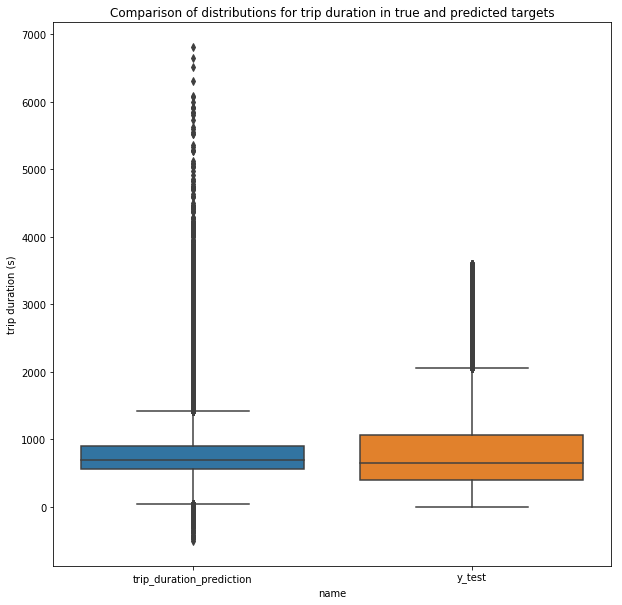

In [523]:
# Visualize distributions of trip duration for true and predicted values
plt.figure(figsize=(10,10))
sns.boxplot(data=df, x='name', y='value')
plt.ylabel("trip duration (s)")
plt.title("Comparison of distributions for trip duration in true and predicted targets")
plt.show()

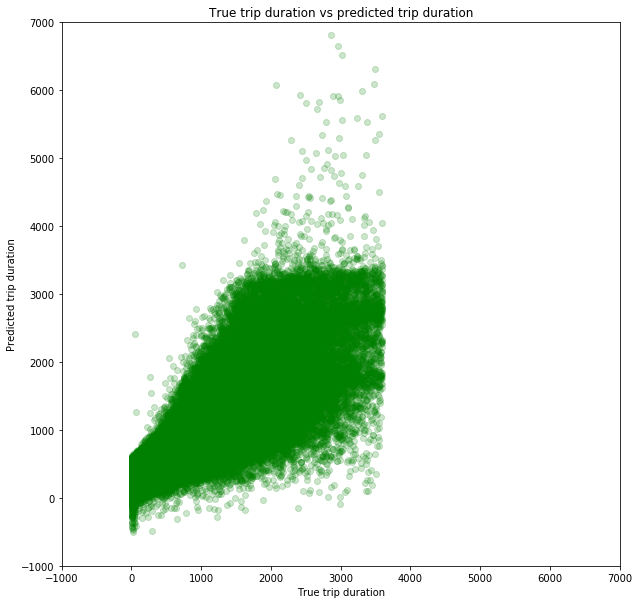

In [520]:
# Visualize linear dependency between true and predicted trip duration
plt.figure(figsize=(10,10))
plt.scatter(x=y_test, y=trip_duration_prediction, color="g", alpha=0.2)
plt.xlim(-1000,7000)
plt.ylim(-1000,7000)
plt.title('True trip duration vs predicted trip duration')
plt.xlabel('True trip duration')
plt.ylabel('Predicted trip duration')
plt.show()

In [497]:
# Calculate RMSE between true and predicted values (in hours)
mean_squared_error(y_test, trip_duration_prediction)/60/60

35.83932079383946

In [498]:
# Calculate r2 score between true and predicted values
r2_score(y_test, trip_duration_prediction, multioutput='variance_weighted')

0.6241016919844575